In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astropy.table import Table

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
tab = Table.read('3dhst_master.phot.v4.1.csv', format='ascii').to_pandas()

## Preprocessing

In [3]:
tab = tab[tab.lmass > 9].copy()

target = 'z_spec'  # spectroscopic redshift
#features = [col for col in tab.columns if (col != target)]

tab['f_F125W_f_F140W'] = tab['f_F125W'] - tab['f_F140W']
tab['f_F125W_f_F160W'] = tab['f_F125W'] - tab['f_F160W']
tab['f_F125W_f_F606W'] = tab['f_F125W'] - tab['f_F606W']
tab['f_F125W_f_F814W'] = tab['f_F125W'] - tab['f_F814W']

tab['f_F140W_f_F160W'] = tab['f_F140W'] - tab['f_F160W']
tab['f_F140W_f_F606W'] = tab['f_F140W'] - tab['f_F606W']
tab['f_F140W_f_F814W'] = tab['f_F140W'] - tab['f_F814W']

tab['f_F160W_f_F606W'] = tab['f_F160W'] - tab['f_F606W']
tab['f_F160W_f_F814W'] = tab['f_F160W'] - tab['f_F814W']

tab['f_F606W_f_F814W'] = tab['f_F606W'] - tab['f_F814W']
features = [col for col in tab.columns if (col != target and col[0:3] == 'f_F' and col[-1] == 'W')]


features = [col for col in features if (col != 'Av') and (col != 'lmass') and (col != 'z_peak') 
            and (col != 'flags') and (col != 'f140w_flag') and (col != 'star_flag') 
            and (col != 'use_phot') and (col != 'near_star')]

tab = tab[(tab[target] > 0)].copy()

label_encoder = LabelEncoder()
tab['field'] = label_encoder.fit_transform(tab['field'])

errors = [col for col in features if (col[:1] == 'e') and (col[-1:] == 'W')]

for error in errors:
    tab[error] = np.where(tab[error] < -90, tab[error].median(), tab[error])

### Train test split

In [22]:
X = tab[features].values
y = tab[target].values

indices = np.arange(len(y))

# first reserve 70% of the data for training, 30% for validation
X_train, X_validate, y_train, y_validate, indices_train, indices_validate = train_test_split(X, y, indices, test_size=0.3, random_state=42)

# second, split the validation set in half to obtain validation and test sets. 
X_validate, X_test, y_validate, y_test, indices_validate, indices_test = train_test_split(X_validate, y_validate, indices_validate, test_size=0.5, random_state=42)

### Model

In [25]:
scaler = StandardScaler()
X_train    = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test     = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_validate_tensor = torch.tensor(X_validate, dtype=torch.float32)
y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validate_dataset = TensorDataset(X_validate_tensor, y_validate_tensor)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [42]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            outputs = self.forward(x_tensor)
            return outputs.numpy().flatten()
        
input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss() # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2000
train_losses = []
val_losses = []

In [49]:
best_val_loss = float('inf')
save_path = "best_model.pth"

for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validate_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(validate_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best model saved at epoch {epoch+1} with val_loss={best_val_loss:.4f}")

Epoch [1/2000], Train Loss: 0.4935, Val Loss: 0.3665
✅ Best model saved at epoch 1 with val_loss=0.3665
Epoch [2/2000], Train Loss: 0.3346, Val Loss: 0.3465
✅ Best model saved at epoch 2 with val_loss=0.3465
Epoch [3/2000], Train Loss: 0.3177, Val Loss: 0.3479
Epoch [4/2000], Train Loss: 0.3046, Val Loss: 0.3376
✅ Best model saved at epoch 4 with val_loss=0.3376
Epoch [5/2000], Train Loss: 0.2997, Val Loss: 0.3014
✅ Best model saved at epoch 5 with val_loss=0.3014
Epoch [6/2000], Train Loss: 0.2769, Val Loss: 0.2887
✅ Best model saved at epoch 6 with val_loss=0.2887
Epoch [7/2000], Train Loss: 0.2658, Val Loss: 0.3169
Epoch [8/2000], Train Loss: 0.2520, Val Loss: 0.2704
✅ Best model saved at epoch 8 with val_loss=0.2704
Epoch [9/2000], Train Loss: 0.2589, Val Loss: 0.2636
✅ Best model saved at epoch 9 with val_loss=0.2636
Epoch [10/2000], Train Loss: 0.2354, Val Loss: 0.2547
✅ Best model saved at epoch 10 with val_loss=0.2547
Epoch [11/2000], Train Loss: 0.2239, Val Loss: 0.2464
✅ Best

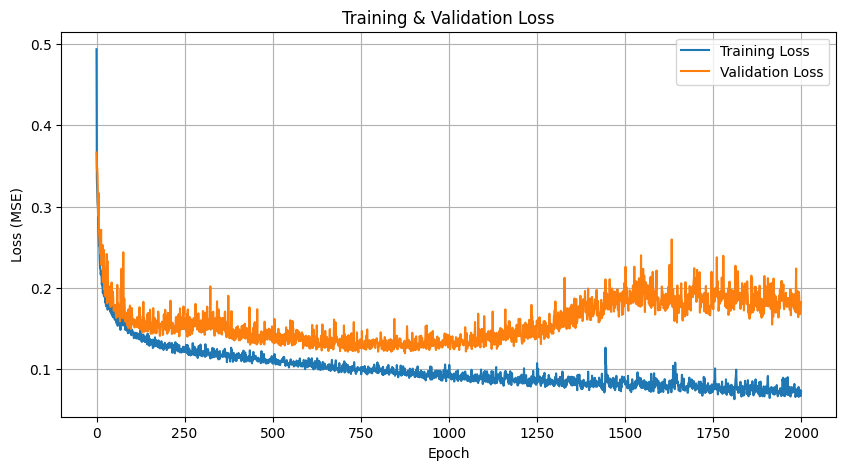

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
mlp = type(model)(input_dim=X_train.shape[1], hidden_dim=128)
mlp.load_state_dict(torch.load(save_path))
mlp.eval()

y_predict = mlp.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

MSE = 0.1101


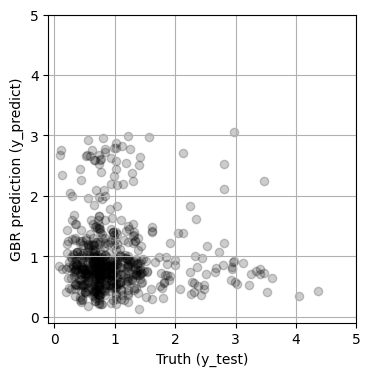

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_validate, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('GBR prediction (y_predict)')
plt.show()

In [56]:
importances = mlp.feature_importances_

fig = plt.figure(0, [8, 16])
ax = fig.add_subplot(111)
ax.barh(np.arange(X.shape[1]), importances, 
        align='center', 
        height=0.5, 
        tick_label=features)
ax.set_xlabel("Feature importance")

plt.show()

AttributeError: 'MLP' object has no attribute 'feature_importances_'

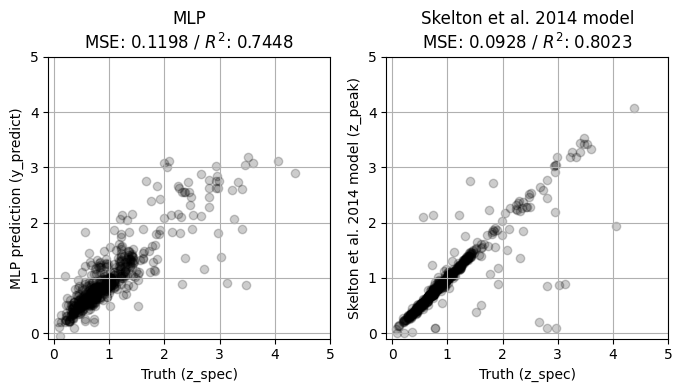

In [57]:
y_predict_validate = mlp.predict(X_validate)
y_skelton2014 = tab['z_peak'].values[indices_validate]

mse_mlp = mean_squared_error(y_validate, y_predict_validate)
r2_mlp = r2_score(y_validate, y_predict_validate)

mse_skelton = mean_squared_error(y_validate, y_skelton2014)
r2_skelton = r2_score(y_validate, y_skelton2014)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(y_validate, y_predict_validate, alpha=0.2, color='black')
ax[0].set_aspect('equal')
ax[0].set_xlim(-0.1, 5)
ax[0].set_ylim(-0.1, 5)
ax[0].grid()
ax[0].set_xlabel('Truth (z_spec)')
ax[0].set_ylabel('MLP prediction (y_predict)')
ax[0].set_title(f'MLP\nMSE: {mse_mlp:.4f} / $R^2$: {r2_mlp:.4f}')


ax[1].scatter(y_validate, y_skelton2014, alpha=0.2, color='black')
ax[1].set_aspect('equal')
ax[1].set_xlim(-0.1, 5)
ax[1].set_ylim(-0.1, 5)
ax[1].grid()
ax[1].set_xlabel('Truth (z_spec)')
ax[1].set_ylabel('Skelton et al. 2014 model (z_peak)')
ax[1].set_title(f'Skelton et al. 2014 model\nMSE: {mse_skelton:.4f} / $R^2$: {r2_skelton:.4f}')

plt.show()

In [5]:
param_grid = {
    'n_estimators': [2000, 2500, 3000],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [5, 7, 9],  
}

xgb = XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 2500}


In [6]:
xgb = grid_search.best_estimator_
y_predict = xgb.predict(X_test)
print(f'MSE = {mean_squared_error(y_test, y_predict):.4f}')

MSE = 0.0919


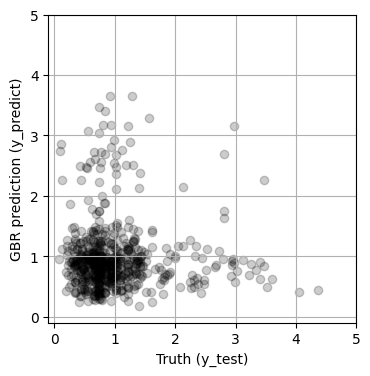

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(y_validate, y_predict, alpha=0.2, color='black')
ax.set_aspect('equal')
ax.set_xlim(-0.1, 5)
ax.set_ylim(-0.1, 5)
ax.grid()
ax.set_xlabel('Truth (y_test)')
ax.set_ylabel('GBR prediction (y_predict)')
plt.show()

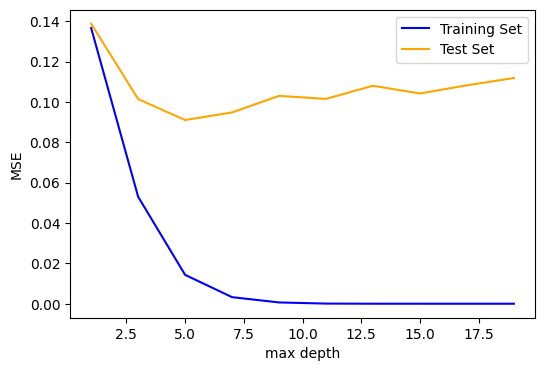

In [8]:
max_depths = np.arange(1, 20, 2).astype(int)

train_mse = []
test_mse = []
for depth in max_depths:
    params = {
        "n_estimators": 2500,
        "learning_rate": 0.01,
        "max_depth": depth,
        "objective": "reg:squarederror",
        "n_jobs": -1,
        "random_state": 42
    }
    xgbrf = XGBRegressor(**params)
    xgbrf.fit(X_train, y_train)

    y_predict_train = xgbrf.predict(X_train)
    y_predict_test = xgbrf.predict(X_test)

    train_mse.append(mean_squared_error(y_train, y_predict_train))
    test_mse.append(mean_squared_error(y_test, y_predict_test))
    
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(max_depths, train_mse, color='blue', label='Training Set')
ax.plot(max_depths, test_mse, color='orange', label='Test Set')
ax.set_xlabel('max depth')
ax.set_ylabel('MSE')
ax.legend()

plt.show()

In [9]:
cv = cross_validate(
    estimator=xgb, 
    X=X,
    y=y, 
    cv=5,
    scoring='neg_mean_squared_error'
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: -0.136 +/- 0.052


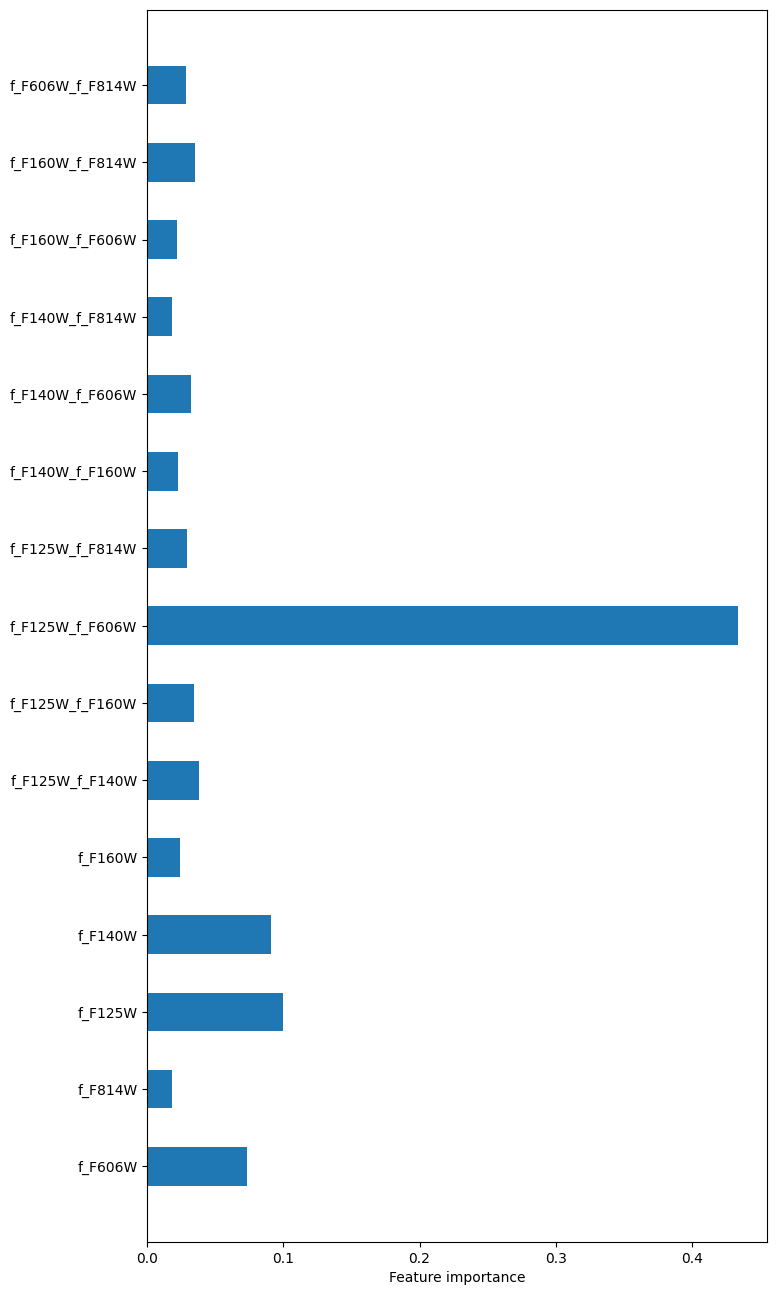

In [10]:
importances = xgb.feature_importances_

fig = plt.figure(0, [8, 16])
ax = fig.add_subplot(111)
ax.barh(np.arange(X.shape[1]), importances, 
        align='center', 
        height=0.5, 
        tick_label=features)
ax.set_xlabel("Feature importance")

plt.show()

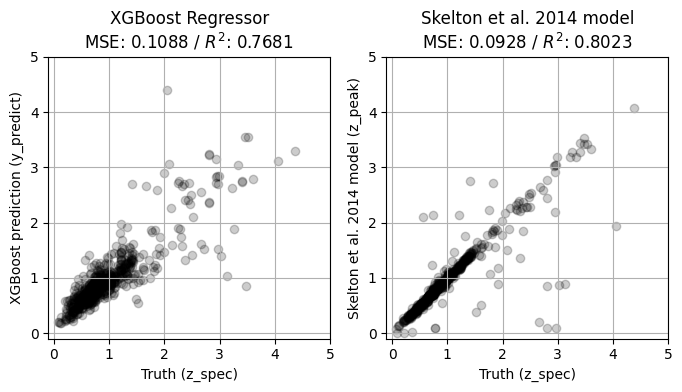

In [11]:
y_predict_validate = xgb.predict(X_validate)
y_skelton2014 = tab['z_peak'].values[indices_validate]

mse_xgb = mean_squared_error(y_validate, y_predict_validate)
r2_xgb = r2_score(y_validate, y_predict_validate)

mse_skelton = mean_squared_error(y_validate, y_skelton2014)
r2_skelton = r2_score(y_validate, y_skelton2014)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].scatter(y_validate, y_predict_validate, alpha=0.2, color='black')
ax[0].set_aspect('equal')
ax[0].set_xlim(-0.1, 5)
ax[0].set_ylim(-0.1, 5)
ax[0].grid()
ax[0].set_xlabel('Truth (z_spec)')
ax[0].set_ylabel('XGBoost prediction (y_predict)')
ax[0].set_title(f'XGBoost Regressor\nMSE: {mse_xgb:.4f} / $R^2$: {r2_xgb:.4f}')


ax[1].scatter(y_validate, y_skelton2014, alpha=0.2, color='black')
ax[1].set_aspect('equal')
ax[1].set_xlim(-0.1, 5)
ax[1].set_ylim(-0.1, 5)
ax[1].grid()
ax[1].set_xlabel('Truth (z_spec)')
ax[1].set_ylabel('Skelton et al. 2014 model (z_peak)')
ax[1].set_title(f'Skelton et al. 2014 model\nMSE: {mse_skelton:.4f} / $R^2$: {r2_skelton:.4f}')

plt.show()